# Overview

Here we have google share prices with open, high, low , close values for a particular day.
Using this data in our LSTM model we will predict the open prices for next 20 days.

Two files:
1. Training File
2. Test File

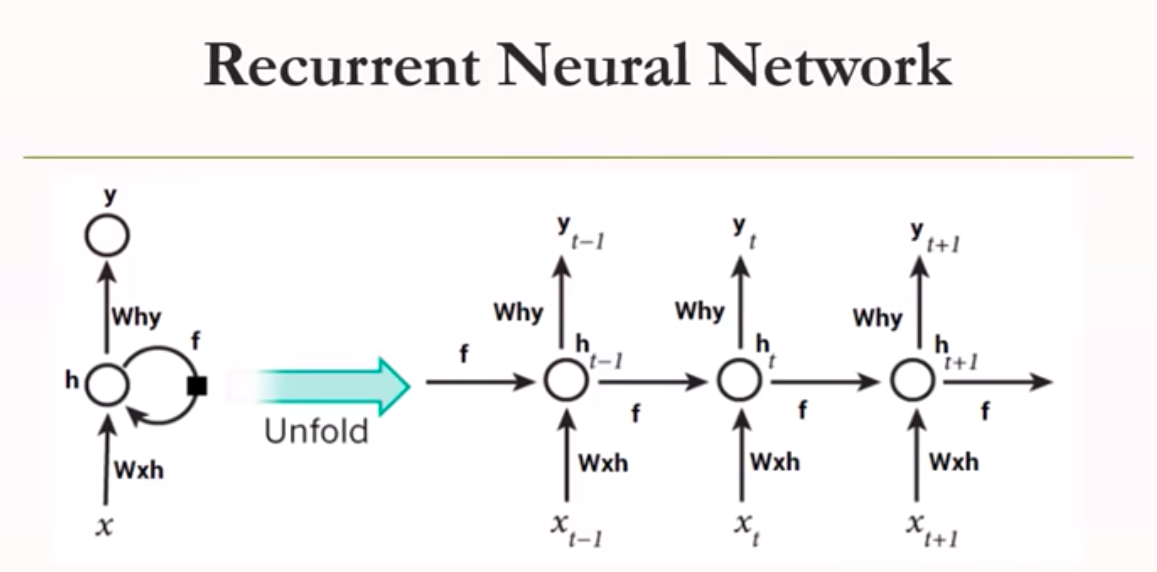

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
#Importing the data
train= pd.read_csv('Price_train.csv')
test= pd.read_csv('Price_test.csv')

In [3]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= train.iloc[:, 1:2].values


In [5]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [6]:
train_open_scaled[60]

array([0.08627874])

Below we will be taking previous 60 days open datasteps to predict the next values so we are converting the data as per our input in LTSM layers.
i.e for taking 0 to 59 days open price to get 60th day price as output, 1 to 60 for 61, 2 to 61 for 62

In [7]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [8]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [9]:
xtrain.shape

(1198, 60, 1)

### Building the LSTM Network

In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [11]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 18s 114ms/step - loss: 0.0325
Epoch 2/100
40/40 [==============================] - 4s 104ms/step - loss: 0.0069
Epoch 3/100
40/40 [==============================] - 4s 104ms/step - loss: 0.0066
Epoch 4/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0057
Epoch 5/100
40/40 [==============================] - 4s 102ms/step - loss: 0.0051
Epoch 6/100
40/40 [==============================] - 4s 102ms/step - loss: 0.0049
Epoch 7/100
40/40 [==============================] - 4s 104ms/step - loss: 0.0048
Epoch 8/100
40/40 [==============================] - 4s 105ms/step - loss: 0.0042
Epoch 9/100
40/40 [==============================] - 4s 106ms/step - loss: 0.0042
Epoch 10/100
40/40 [==============================] - 4s 104ms/step - loss: 0.0049
Epoch 11/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0042
Epoch 12/100
40/40 [==============================] - 5s 116ms/step - loss: 0.0039
Epoch 13/100

### Predicting for test data

As we have 60 input in our layer, we will concatenate our train and test and will take last 60 values of our training set with test set

In [12]:

test_open= test.iloc[:, 1:2].values #taking  open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [13]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [14]:
xtest= np.array(xtest)

In [15]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

1/1 [==============================] - 3s 3s/step


In [16]:
predicted_value= ss.inverse_transform(predicted_value)

### Plotting the data

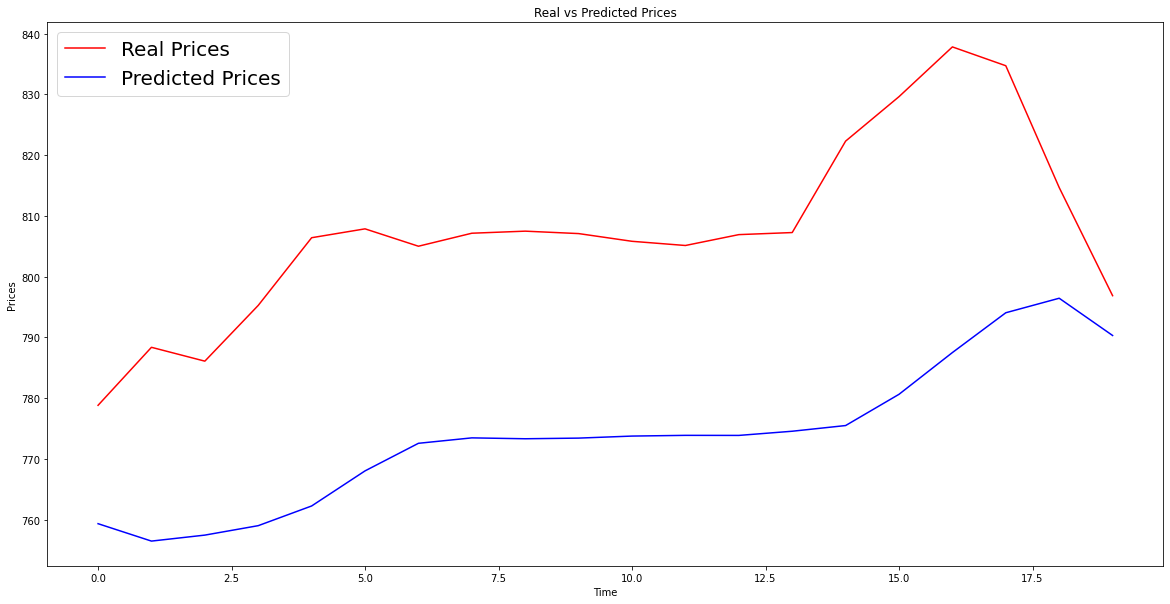

In [17]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)


In [18]:
from keras.wrappers.scikit_learn import KerasRegressor

In [19]:
def reg(optimizer):
    #initialisizng the model 
    regression= Sequential()

    #First Input layer and LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
    regression.add(Dropout(0.2))

    # Second LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer= 'glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Third LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
    regression.add(Dropout(0.2))
    #Output layer , we wont pass any activation as its continous value model
    regression.add(Dense(units=1))

    #Compiling the network
    regression.compile(optimizer=optimizer,loss='mean_squared_error')
    
    return regression

model= KerasRegressor(build_fn=reg)

C:\Users\He336\AppData\Local\Temp\ipykernel_14020\2440103601.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model= KerasRegressor(build_fn=reg)


In [20]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam', 'rmsprop','sgd','adadelta']}
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(xtrain, ytrain)
best_parameters = grid_search.best_params_

Epoch 1/25
20/20 [==============================] - 24s 151ms/step - loss: 0.0619
Epoch 2/25
20/20 [==============================] - 3s 126ms/step - loss: 0.0193
Epoch 3/25
20/20 [==============================] - 3s 131ms/step - loss: 0.0195
Epoch 4/25
20/20 [==============================] - 3s 136ms/step - loss: 0.0150
Epoch 5/25
20/20 [==============================] - 3s 165ms/step - loss: 0.0138
Epoch 6/25
20/20 [==============================] - 3s 137ms/step - loss: 0.0139
Epoch 7/25
20/20 [==============================] - 2s 120ms/step - loss: 0.0131
Epoch 8/25
20/20 [==============================] - 3s 133ms/step - loss: 0.0095
Epoch 9/25
20/20 [==============================] - 3s 125ms/step - loss: 0.0123
Epoch 10/25
20/20 [==============================] - 2s 121ms/step - loss: 0.0089
Epoch 11/25
20/20 [==============================] - 2s 123ms/step - loss: 0.0103
Epoch 12/25
20/20 [==============================] - 3s 129ms/step - loss: 0.0088
Epoch 13/25
20/20 [=====

In [21]:
model=grid_search.best_estimator_.fit(xtrain,ytrain)

Epoch 1/25
24/24 [==============================] - 24s 179ms/step - loss: 0.0529
Epoch 2/25
24/24 [==============================] - 4s 184ms/step - loss: 0.0080
Epoch 3/25
24/24 [==============================] - 4s 186ms/step - loss: 0.0060
Epoch 4/25
24/24 [==============================] - 4s 179ms/step - loss: 0.0056
Epoch 5/25
24/24 [==============================] - 4s 180ms/step - loss: 0.0063
Epoch 6/25
24/24 [==============================] - 5s 192ms/step - loss: 0.0051
Epoch 7/25
24/24 [==============================] - 4s 179ms/step - loss: 0.0052
Epoch 8/25
24/24 [==============================] - 4s 180ms/step - loss: 0.0049
Epoch 9/25
24/24 [==============================] - 4s 182ms/step - loss: 0.0043
Epoch 10/25
24/24 [==============================] - 5s 188ms/step - loss: 0.0045
Epoch 11/25
24/24 [==============================] - 4s 185ms/step - loss: 0.0044
Epoch 12/25
24/24 [==============================] - 4s 184ms/step - loss: 0.0042
Epoch 13/25
24/24 [=====

In [22]:
model

1/1 [==============================] - 3s 3s/step


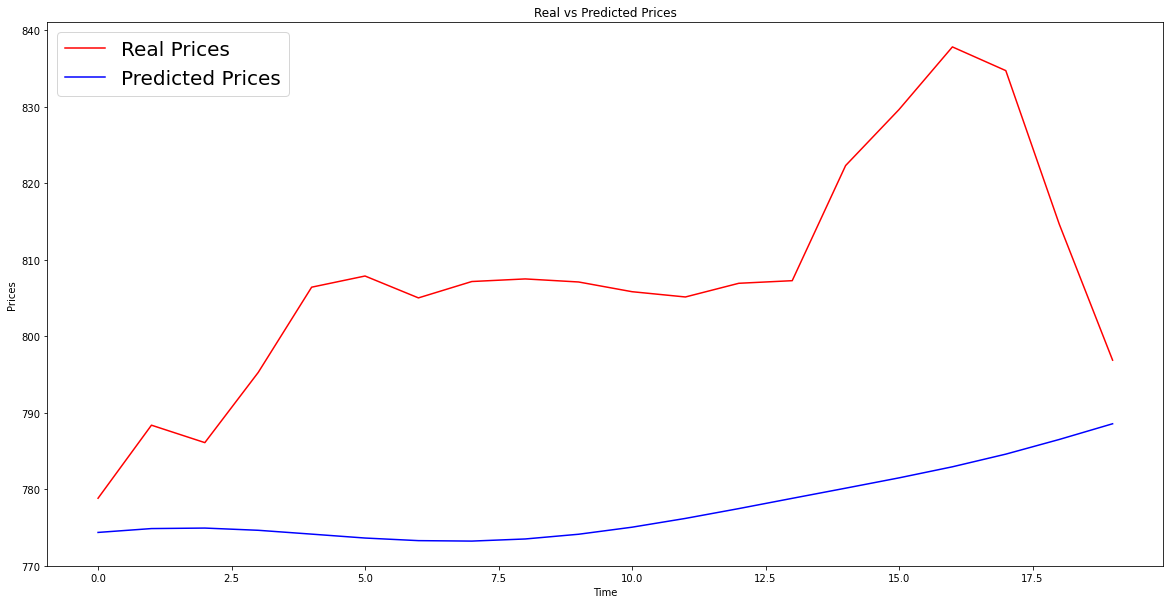

In [23]:
predicted_value= grid_search.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value.reshape(-1,1))


plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)
